In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from scipy.ndimage import filters
import os
from tqdm import tqdm_notebook as tqdm
import math

In [2]:
def warping(img, f):
    warped_image = np.zeros(img.shape, dtype=int)
    # f = 1 / 0.018 * 100
    img_h = img.shape[0]
    img_w = img.shape[1]
    y0 = img_h // 2;
    x0 = img_w // 2;
    new_left, new_right = img_w - 1, 0
    for y_new in range(img_h):
        for x_new in range(img_w):
            x = f * math.tan((x_new - x0) / f)
            y = math.sqrt(x * x + f * f) * (y_new - y0) / f
            x = x + x0
            y = y + y0
            x = round(x)
            y = round(y)
            if(0 <= x) and (x < img_w) and (0 <= y) and (y < img_h):
                warped_image[y_new][x_new] = img[y][x]
                # print(y_new, x_new, y, x)
                if(x_new < new_left):
                    new_left = x_new
                elif(x_new > new_right):
                    new_right = x_new
            else:
                warped_image[y_new][x_new][0] = warped_image[y_new][x_new][1] = warped_image[y_new][x_new][2] = 0

    # print(new_left, new_right)
    return warped_image[:, new_left:new_right].astype('uint8')

In [3]:
def featureDetect(pic, window = 9, num_points = 256, descriptor_window = 5):
    gray_image = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
    img = np.copy(gray_image)
    sigma = 3
    imx = np.zeros(img.shape)
    imy = np.zeros(img.shape)
    filters.gaussian_filter(img, (sigma, sigma), (0, 1), imx)
    filters.gaussian_filter(img, (sigma, sigma), (1, 0), imy)

    # compute components of the Harris matrix
    Ixx = filters.gaussian_filter(imx*imx,sigma)
    Ixy = filters.gaussian_filter(imx*imy,sigma)
    Iyy = filters.gaussian_filter(imy*imy,sigma)

    det = Ixx*Iyy - Ixy**2
    trace = Ixx + Iyy
    #R = det / trace
    R = det - 0.05 * trace**2

    offset = window // 2
    R[:offset, :] = 0
    R[-offset:, :] = 0
    R[:, :offset] = 0
    R[:, -offset:] = 0
    local_max = filters.maximum_filter(R, (offset, offset))
    R = R * (R == local_max)
    #print(R)

    sort_idx = np.argsort(R.flatten())[-num_points:]

    x = sort_idx // img.shape[1]
    y = sort_idx % img.shape[1]
    marked_pic = np.copy(pic)
    #print(x, y)
    descriptor = np.array([]).reshape(0, descriptor_window**2)
    for x_, y_ in zip(x, y):
        neighbors = []
        neighbor_offset = descriptor_window // 2
        for i in range(-neighbor_offset, neighbor_offset + 1):
            for j in range(-neighbor_offset, neighbor_offset + 1):
                if (x_ + i >= img.shape[0] or y_ + j >= img.shape[1]):
                    neighbors.append(0)
                else:
                    neighbors.append(img[x_+i, y_+j])
        #print(neighbors)
        descriptor = np.concatenate((descriptor, np.array([neighbors])))
        cv2.circle(marked_pic,(y_, x_), 2, (255,0,0), -1)
    #print(descriptor.shape)
    #plt.imshow(marked_pic)
    #print(np.vstack((x, y)))
    return marked_pic, np.vstack((x, y)).T, descriptor

In [4]:
def func(x): 
    return int(x.split(".")[0])
def READImages(directory):
    print(os.listdir(directory))
    images_name = sorted([filename for filename in os.listdir(directory) if filename[-3:] == 'JPG'], key = func)
    print(images_name)
    return np.array([cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(directory, image)), 
                                             cv2.COLOR_BGR2RGB)
                                , (0,0), fx=0.1, fy=0.1)
                     for image in images_name])

def readImages(directory):
    print(os.listdir(directory))
    images_name = sorted([filename for filename in os.listdir(directory) if filename[-3:] == 'jpg'])
    print(images_name)
    return np.array([cv2.imread(os.path.join(directory, image)) for image in images_name])


In [5]:
def featureMatching(picture1, picture2, descriptors1, descriptors2, indices1, indices2):
    picture = np.concatenate((picture1, picture2), 1)
    #plt.imshow(picture)
    #print(picture.shape, indices1.shape, indices2.shape)
    feature_pairs = []
    for i, descriptor1 in tqdm(enumerate(descriptors1)):
        #print(indices1[i])
        difference = []
        for j, descriptor2 in enumerate(descriptors2):
#            print(np.sum(np.absolute(descriptor1 - descriptor2)))
            difference.append(np.sum(np.absolute(descriptor1 - descriptor2)))
        match_point = np.argsort(difference)[0]
        second_match_point = np.argsort(difference)[1]
        if difference[match_point] < 4200 and difference[second_match_point] - difference[match_point] > 200 :
            #plt.plot([indices1[i][1], indices2[match_point][1]+384], [indices1[i][0], indices2[match_point][0]], 'r-', lw = 0.7)
            start_point = (indices1[i][1], indices1[i][0])
            end_point = (indices2[match_point][1], indices2[match_point][0])
            feature_pairs.append(np.array([np.array(start_point), np.array(end_point)]))
            
            end_point = (indices2[match_point][1]+picture2.shape[1], indices2[match_point][0])
            cv2.line(picture, start_point, end_point, (255, 255, 0), 3)
        #print(difference[match_point], difference[second_match_point])
        #print(i, match_point, difference[match_point])
    return picture, np.array(feature_pairs)

In [6]:
def multi_band_blending(img1, img2, overlap_w):
    def preprocess(img1, img2, overlap_w):

        w1 = img1.shape[1]
        w2 = img2.shape[1]

        shape = np.array(img1.shape)

        shape[1] = w1 + w2 - overlap_w

        subA, subB, mask = np.zeros(shape), np.zeros(shape), np.zeros(shape)
        print("shape", shape, "img1:", img1.shape, "img2", img2.shape, "overlap", overlap_w)
        subA[:, :w1] = img1
        subB[:, w1 - overlap_w:] = img2
        mask[:, :w1 - overlap_w // 2] = 1

        return subA, subB, mask


    def Gaussian(img, leveln):
        GP = [img]
        for i in range(leveln - 1):
            GP.append(cv2.pyrDown(GP[i]))
        return GP


    def Laplacian(img, leveln):
        LP = []
        for i in range(leveln - 1):
            next_img = cv2.pyrDown(img)
            # print(img.shape, cv2.pyrUp(next_img, img.shape[1::-1]).shape)
            LP.append(img - cv2.pyrUp(next_img, dstsize = img.shape[1::-1]))
            img = next_img
        LP.append(img)
        return LP


    def blend_pyramid(LPA, LPB, MP):
        blended = []
        for i, M in enumerate(MP):
            blended.append(LPA[i] * M + LPB[i] * (1.0 - M))
        return blended


    def reconstruct(LS):
        img = LS[-1]
        for lev_img in LS[-2::-1]:
            img = cv2.pyrUp(img, dstsize = lev_img.shape[1::-1])
            img += lev_img
        return img
    
    subA, subB, mask = preprocess(img1, img2, overlap_w)

    leveln = int(np.floor(np.log2(min(img1.shape[0], img1.shape[1],
                                          img2.shape[0], img2.shape[1]))))
   
    print("max level", leveln)
    leveln = 8
    print("level", leveln)
    # Get Gaussian pyramid and Laplacian pyramid
    MP = Gaussian(mask, leveln)
    LPA = Laplacian(subA, leveln)
    LPB = Laplacian(subB, leveln)

    # Blend two Laplacian pyramidspass
    blended = blend_pyramid(LPA, LPB, MP)

    # Reconstruction process
    result = np.clip(reconstruct(blended), 0, 255)

    return result.astype(int)

In [19]:
from random import randint
def imageMatching(pic1, pic2, feature_pairs, prev_shift=0, prev_top_pad = 0, prev_bot_pad = 0):
    print('number of feature pairs', feature_pairs.shape[0])
    h = pic1.shape[0]
    w = pic1.shape[1]
    shift = feature_pairs[:, 0, :] - feature_pairs[:, 1, :]
    times = 200
    inlier_max = 0
    best_shift = [0, 0]
    for t in range(times):
        sample_pair = randint(0, feature_pairs.shape[0] - 1)
        sample_shift = feature_pairs[sample_pair][0] - feature_pairs[sample_pair][1]
        #print(sample_shift)
        inlier_num = np.sum(np.sum(abs(shift - sample_shift), 1) < 5)
        if inlier_num > inlier_max:
            inlier_max = inlier_num
            best_shift = sample_shift
    print('votes', inlier_max)
#   match_image = np.concatenate((pic1, pic2[:, best_shift[0]//2:]), 1)
    vertical_shift = best_shift[1]
    horizontal_shift = best_shift[0]
    match_image_height = abs(vertical_shift) + max(pic1.shape[0], pic2.shape[0])
    print(match_image_height)
    left_padding = np.zeros((match_image_height - pic1.shape[0], pic1.shape[1], 3), dtype = np.int8)
    right_padding = np.zeros((match_image_height - pic2.shape[0], pic2.shape[1], 3), dtype = np.int8)
    print(pic2.shape[0], vertical_shift, prev_top_pad, prev_bot_pad, pic1.shape[0])
    if prev_shift == 0:
        if vertical_shift > 0:
            Up = 1
            left_pic = np.concatenate((pic1, left_padding), axis = 0)
            right_pic = np.concatenate((right_padding, pic2), axis = 0)
            up_pad = 0
            down_pad = match_image_height - pic1.shape[0]
        elif vertical_shift < 0:
            Up = -1
            left_pic = np.concatenate((left_padding, pic1), axis = 0)
            right_pic = np.concatenate((pic2, right_padding), axis = 0)
            up_pad = match_image_height - pic1.shape[0]
            down_pad = 0
        else:
            left_pic = np.copy(pic1)
            right_pic = np.copy(pic2)
            up_pad = 0
            down_pad = 0
            Up = 0
    elif vertical_shift > 0 and pic1.shape[0] + abs(vertical_shift) + prev_bot_pad < pic2.shape[0]:
        Up = 1
        pad = np.zeros((pic2.shape[0] - pic1.shape[0] - abs(vertical_shift) - prev_bot_pad, pic1.shape[1], 3), dtype = np.int8)
        left_padding = np.zeros((abs(vertical_shift) + prev_bot_pad, pic1.shape[1], 3), dtype = np.int8)
        left_pic = np.concatenate((pad, pic1, left_padding), axis = 0)
        right_pic = np.copy(pic2)
        up_pad = pic2.shape[0] - pic1.shape[0] - abs(vertical_shift) - prev_bot_pad
        down_pad = abs(vertical_shift) + prev_bot_pad
    elif vertical_shift < 0 and pic1.shape[0] + abs(vertical_shift) + prev_top_pad < pic2.shape[0]:
        Up = -1
        pad = np.zeros((pic2.shape[0] - pic1.shape[0] - abs(vertical_shift) - prev_top_pad, pic1.shape[1], 3), dtype = np.int8)
        left_padding = np.zeros((abs(vertical_shift) + prev_top_pad, pic1.shape[1], 3), dtype = np.int8)
        left_pic = np.concatenate((left_padding, pic1, pad), axis = 0)
        right_pic = np.copy(pic2)
        up_pad = abs(vertical_shift) + prev_top_pad
        down_pad = pic2.shape[0] - pic1.shape[0] - abs(vertical_shift) - prev_top_pad
    elif vertical_shift > 0:
        Up = 1
        left_pic = np.concatenate((pic1, left_padding), axis = 0)
        right_pic = np.concatenate((right_padding, pic2), axis = 0)
        up_pad = 0
        down_pad = match_image_height - pic1.shape[0]
    elif vertical_shift < 0:
        Up = -1
        left_pic = np.concatenate((left_padding, pic1), axis = 0)
        right_pic = np.concatenate((pic2, right_padding), axis = 0)
        up_pad = match_image_height - pic1.shape[0]
        down_pad = 0
    else:
        pad = np.zeros((prev_bot_pad, pic1.shape[1], 3), dtype = np.int8)
        left_padding = np.zeros((prev_top_pad, pic1.shape[1], 3), dtype = np.int8)
        left_pic = np.concatenate((left_padding, pic1, pad), axis = 0)
        right_pic = np.copy(pic2)
        up_pad = 0
        down_pad = 0
        Up = 0
    
    
    # if(horizontal_shift < 0):
    #     left_pic, right_pic = right_pic, left_pic
    #print(left_pic.shape, right_pic.shape)
    print("shift:", best_shift)
    plt.imsave("test_l.png", np.array(left_pic, dtype=np.uint8))
    plt.imsave("test_r.png", np.array(right_pic, dtype=np.uint8))
    match_image = multi_band_blending(left_pic, right_pic, w - best_shift[0])
    #half_shift = (w - best_shift[0]) // 2
    #match_image = np.concatenate((left_pic[:, :w-half_shift], right_pic[:, half_shift:]), 1)
    #plt.imshow(match_image)
    #print(inlier_max)

    return match_image, Up, up_pad, down_pad

In [9]:
'''
if __name__ == "__main__":
    print("starting")
    original_images = READImages('images/1F/')
    images = np.array([warping(i, 5000) for i in tqdm(original_images)][::-1])
    print(images)
'''

starting


In [23]:
original_images = READImages('images/outdoor/')
images = np.array([warping(i, 5000) for i in tqdm(original_images)][::-1])

['8.JPG', '9.JPG', '11.JPG', '10.JPG', '5.123.JPG', '4.JPG', '6.123.JPG', '7.JPG', '2.JPG', '3.JPG']
['2.JPG', '3.JPG', '4.JPG', '5.123.JPG', '6.123.JPG', '7.JPG', '8.JPG', '9.JPG', '10.JPG', '11.JPG']


<ipython-input-23-3f11b0c97fda>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  images = np.array([warping(i, 5000) for i in tqdm(original_images)][::-1])


  0%|          | 0/10 [00:00<?, ?it/s]

(10, 400, 599, 3)


<ipython-input-24-edecb5e38964>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, pic in tqdm(enumerate(images)):


0it [00:00, ?it/s]

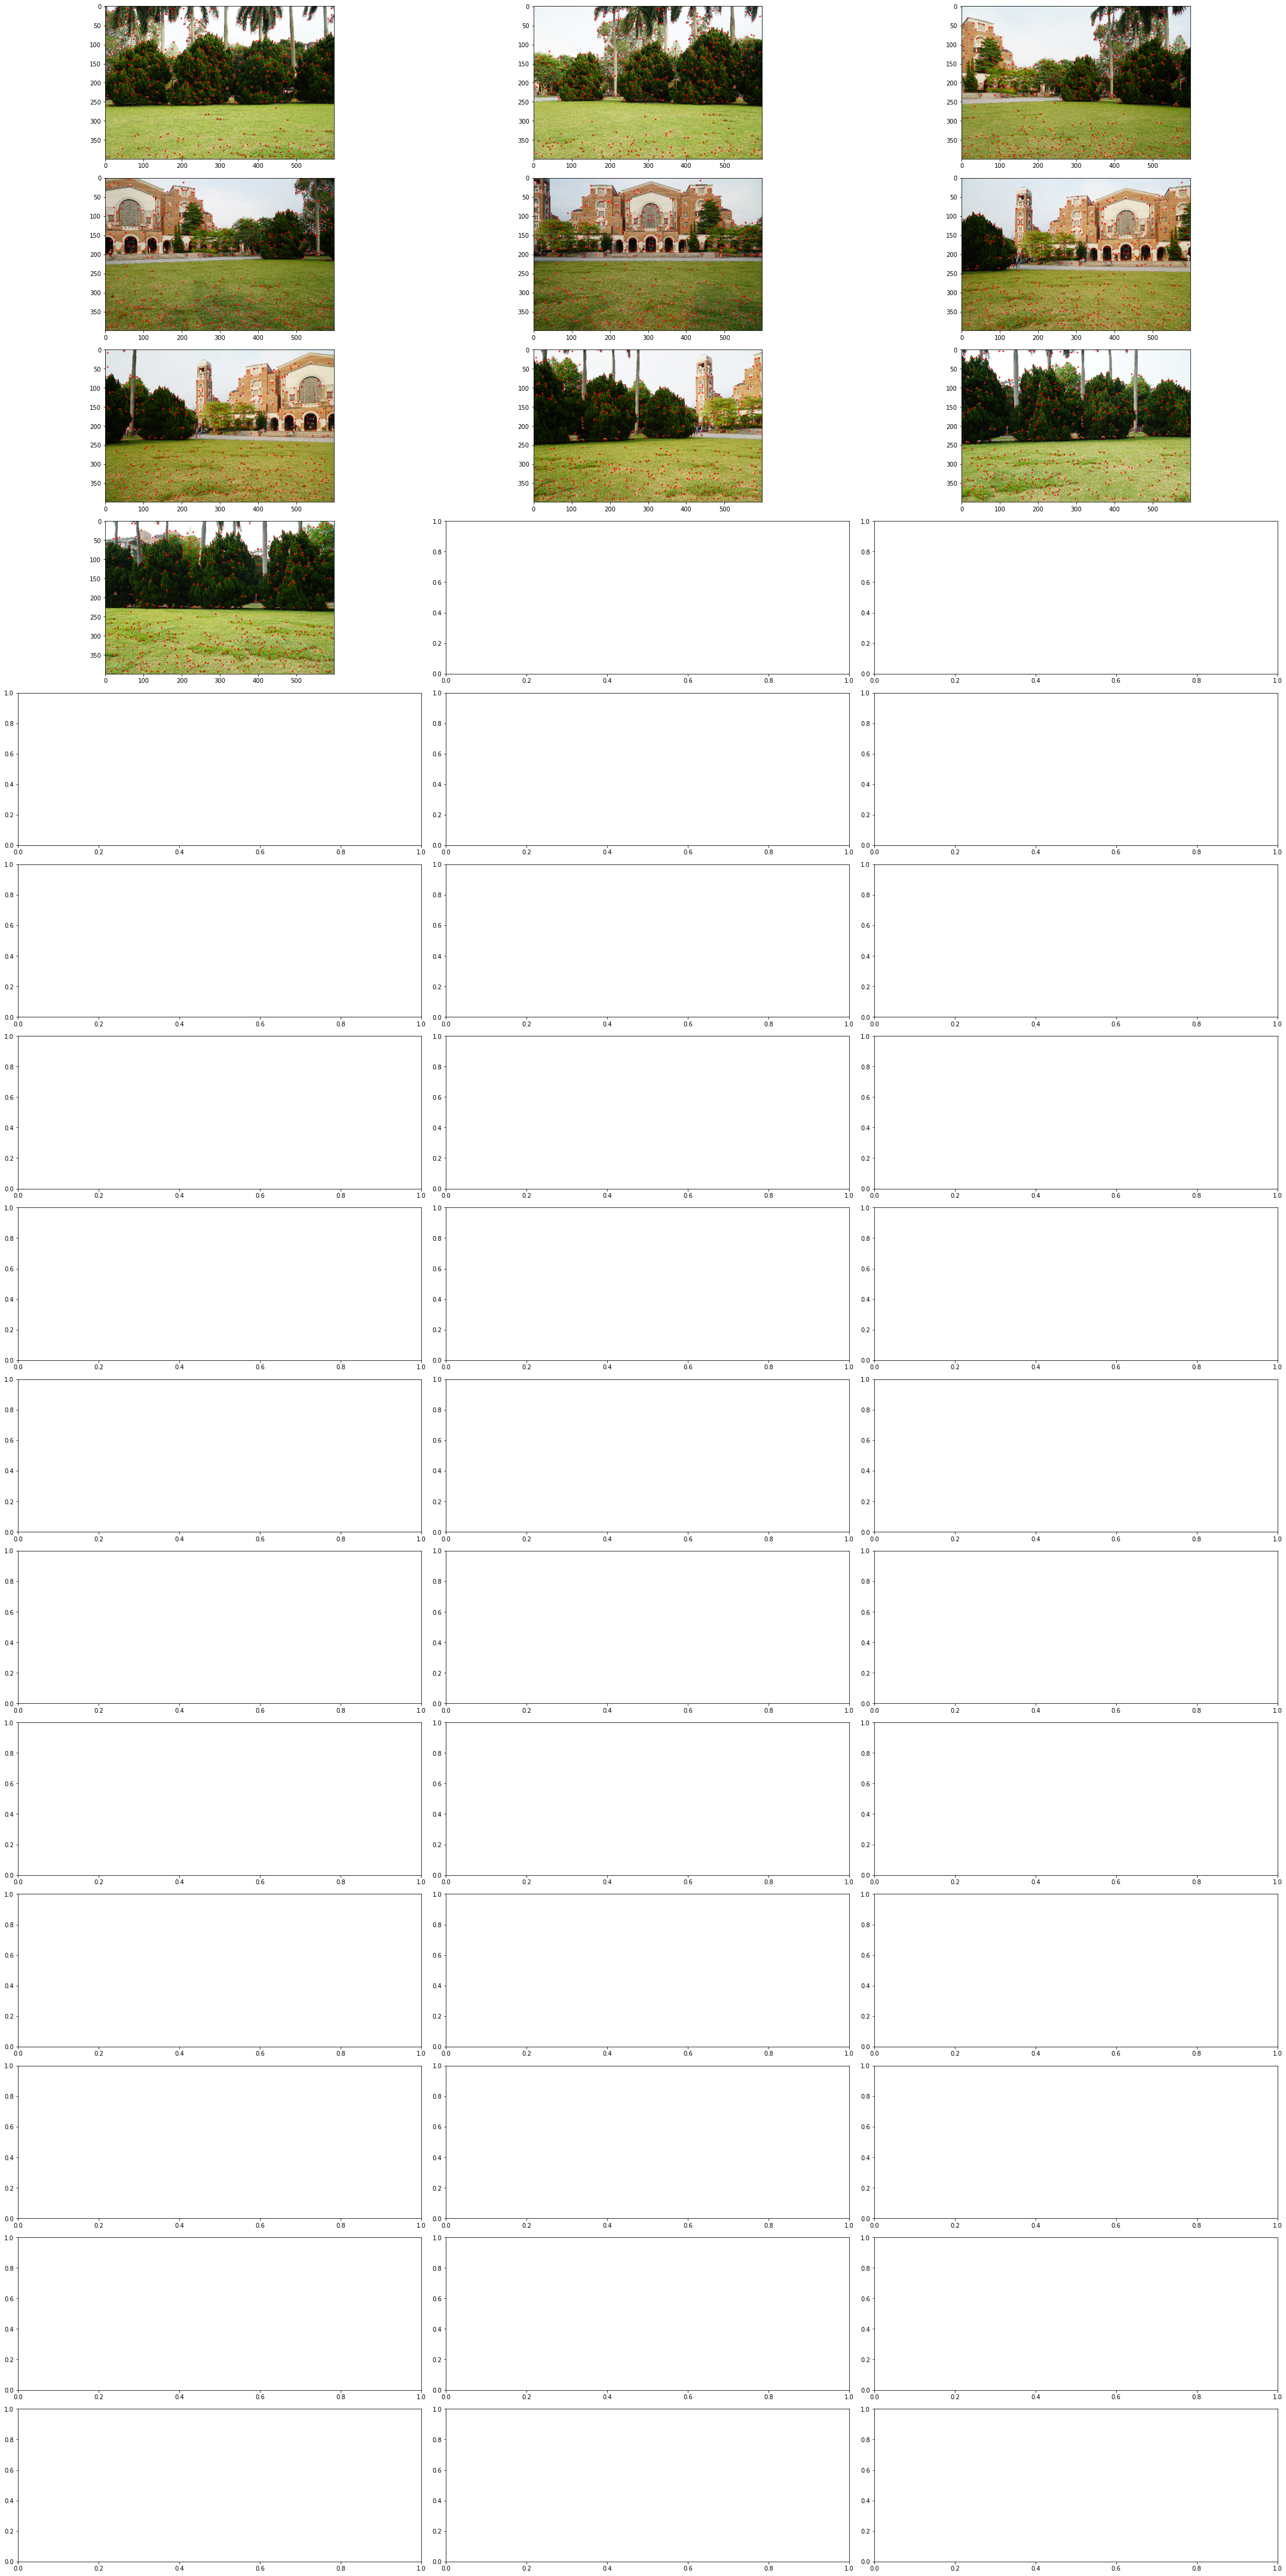

In [24]:
picture = images[0]
print(images.shape)
height = picture.shape[0]
width = picture.shape[1]
#plt.imshow(picture)
# print(height, width)
#small_pic = picture[:int(height*0.2), :int(width*0.2)]
#pic = np.copy(picture)
fig, axes = plt.subplots(15, 3, figsize = (30, 60))
fig.tight_layout()
marked_images = []
feature_indicies = []
feature_descriptors = []
for i, pic in tqdm(enumerate(images)):
    # print(i, pic)
    marked_img, indicies, descriptor = featureDetect(pic, window = 13, num_points = 500, descriptor_window = 9)
    marked_images.append(marked_img)
    feature_indicies.append(indicies)
    feature_descriptors.append(descriptor)
    r = int(i / 3)
    c = int(i % 3)
    axes[r][c].imshow(marked_img)
plt.show()

<ipython-input-5-f011843df0b6>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, descriptor1 in tqdm(enumerate(descriptors1)):


0it [00:00, ?it/s]

number of feature pairs 89
votes 12
405
400 -5 0 0 400
shift: [187  -5]
shape [405 786   3] img1: (405, 599, 3) img2 (405, 599, 3) overlap 412
max level 8
level 8


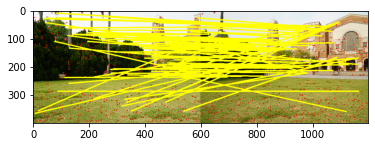

In [25]:
i = 6
match_picture, feature_pairs = featureMatching(marked_images[i + 1], marked_images[i], feature_descriptors[i + 1], 
                                               feature_descriptors[i], feature_indicies[i + 1], feature_indicies[i])
plt.imshow(match_picture)
merged_image, up_shift, _, _ = imageMatching(marked_images[i + 1], marked_images[i], feature_pairs)
plt.imsave("out-test.png", np.array(merged_image, dtype=np.uint8))

<ipython-input-5-f011843df0b6>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, descriptor1 in tqdm(enumerate(descriptors1)):


0it [00:00, ?it/s]

number of feature pairs 101
votes 19
404
400 -4 0 0 400
shift: [195  -4]
shape [404 794   3] img1: (404, 599, 3) img2 (404, 599, 3) overlap 404
max level 8
level 8


0it [00:00, ?it/s]

number of feature pairs 76
votes 7
410
404 6 4 0 400
shift: [177   6]
shape [410 971   3] img1: (410, 599, 3) img2 (410, 794, 3) overlap 422
max level 8
level 8


0it [00:00, ?it/s]

number of feature pairs 85
votes 4
428
410 -18 0 10 400
shift: [159 -18]
shape [ 428 1130    3] img1: (428, 599, 3) img2 (428, 971, 3) overlap 440
max level 8
level 8


0it [00:00, ?it/s]

number of feature pairs 132
votes 32
431
428 -3 28 0 400
shift: [230  -3]
shape [ 431 1360    3] img1: (431, 599, 3) img2 (431, 1130, 3) overlap 369
max level 8
level 8


0it [00:00, ?it/s]

number of feature pairs 106
votes 23
453
431 22 31 0 400
shift: [124  22]
shape [ 431 1484    3] img1: (431, 599, 3) img2 (431, 1360, 3) overlap 475
max level 8
level 8


0it [00:00, ?it/s]

number of feature pairs 175
votes 59
435
431 -4 9 22 400
shift: [96 -4]
shape [ 431 1580    3] img1: (431, 599, 3) img2 (431, 1484, 3) overlap 503
max level 8
level 8


0it [00:00, ?it/s]

number of feature pairs 89
votes 12
436
431 -5 13 18 400
shift: [187  -5]
shape [ 431 1767    3] img1: (431, 599, 3) img2 (431, 1580, 3) overlap 412
max level 8
level 8


0it [00:00, ?it/s]

number of feature pairs 83
votes 10
436
431 -5 18 13 400
shift: [183  -5]
shape [ 431 1950    3] img1: (431, 599, 3) img2 (431, 1767, 3) overlap 416
max level 8
level 8


0it [00:00, ?it/s]

number of feature pairs 76
votes 11
443
431 -12 23 8 400
shift: [277 -12]
shape [ 443 2227    3] img1: (443, 599, 3) img2 (443, 1950, 3) overlap 322
max level 8
level 8


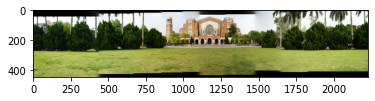

In [28]:
previous_image = images[0]
feature_matching = []
up_shift = 0
top_pad = 0
botton_pad = 0
for i in range(0, images.shape[0] - 1):
    match_picture, feature_pairs = featureMatching(marked_images[i + 1], marked_images[i], feature_descriptors[i + 1], 
                                                   feature_descriptors[i], feature_indicies[i + 1], 
                                                   feature_indicies[i])
    feature_matching.append(match_picture)
    merged_image, up_shift, top_pad, botton_pad = imageMatching(images[i + 1], previous_image, feature_pairs, up_shift, top_pad, botton_pad)
    previous_image = merged_image
plt.imshow(previous_image)


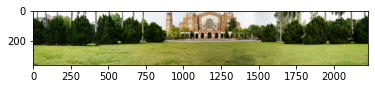

In [33]:

y, y1 = 650, 540
crop = previous_image[40 : 400, :]
#plt.imsave('outdoor.jpg',np.array(crop, dtype=np.uint8))
plt.imshow(crop)
plt.imsave('the_real_outdoor.jpg',np.array(crop, dtype=np.uint8))